In [1]:
import pandas as pd
import seaborn as sns
import plotly_express as px
from pandas import DataFrame
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
import pyLDAvis.gensim_models
from gensim import corpora
import pyLDAvis
from gensim import models

from surprise import Reader, Dataset, SVD
from sklearn.manifold import TSNE

import scipy.sparse
from sklearn.decomposition import TruncatedSVD, PCA

from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

from karateclub import Node2Vec
from sklearn.cluster import DBSCAN
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import silhouette_score

from mlxtend import frequent_patterns
import numpy as np
from pyvis.network import Network

In [2]:
recommendations_df = pd.read_csv("./data/recommendations.csv")
recommendations_df.head(2)

C:\Users\A\AppData\Local\Temp\ipykernel_16088\1721041378.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  recommendations_df = pd.read_csv("./data/recommendations.csv")


app_id  helpful  funny        date is_recommended  hours  user_id  \
0  975370        0      0  2022-12-12           True   36.3  51580.0   
1  304390        4      0  2017-02-17          False   11.5   2586.0   

   review_id  
0        0.0  
1        1.0

In [3]:
games_df = pd.read_csv("./data/games.csv")
games_meta_df = pd.read_json("./data/games_metadata.json", lines=True, orient="records")
users_df = pd.read_csv("./data/users.csv")
merged_games_df = games_df.merge(games_meta_df, on='app_id', how='left')

In [4]:
print("Users_df")
users_df.head(2)

Users_df


user_id  products  reviews
0   7360263       359        0
1  14020781       156        1

### Datasets Card

In [109]:
def fig(df, x, y, title, labels):
  fig1 = px.bar(df, x=x, y=y, title=title, labels=labels)

  fig1.update_layout(
      width=900, 
      height=600,
      title_font_size=18,  
      xaxis_title_font_size=16,
      yaxis_title_font_size=16,
      font=dict(size=16)
  )
  fig1.show()

def fig_pie(df, names, values, title, transform=False):
  if(transform):
    df[names] = df[names].replace({True: "Recommended", False: "Not Recommended"})
  fig1 = px.pie(df, names=names, values=values, title=title, hole=0.3)
  fig1.update_layout(
      width=900, 
      height=600,
      title_font_size=18,  
      xaxis_title_font_size=16,
      yaxis_title_font_size=16,
      font=dict(size=16)
  )
  fig1.show()

In [93]:
games_df['year_release'] = pd.to_datetime(games_df['date_release']).dt.year
hist_years = games_df.groupby('year_release')['app_id'].nunique().reset_index()

rating_count = games_df['rating'].value_counts().reset_index()
rating_count.columns = ['Rating', 'Count']

fig(hist_years, x='year_release', y='app_id', title='Count of Distinct Game IDs by Release Year', labels={'year_release': 'Release Year', 'app_id': 'Distinct Game IDs'})
fig_pie(rating_count, names='Rating', values='Count', title='Distribution of Game Ratings')


In [110]:
hist_years_2 = recommendations_df.groupby("year")["review_id"].nunique().reset_index()
recommended_count = recommendations_df['is_recommended'].value_counts().reset_index()
recommended_count.columns = ['Is Recommended', 'Count']

fig(hist_years_2, x="year", y="review_id", title='Count of Distinct Reviews IDs by Release Year', labels={"year": "Review Year", "review_id": "Distinct Review IDs"})
fig_pie(recommended_count, names="Is Recommended", values="Count",  title="Distribution of Recommended Games", transform=True)

# Preliminary visualisation

### Users: What are the standard profiles of Steam's users?

In [5]:
print("Nb of users: ", users_df["user_id"].count())
users_df.describe() 

Nb of users:  14306064


user_id      products       reviews
count  1.430606e+07  1.430606e+07  1.430606e+07
mean   7.153032e+06  1.163734e+02  2.876738e+00
std    4.129805e+06  2.438515e+02  7.987421e+00
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    3.576516e+06  2.300000e+01  1.000000e+00
50%    7.153032e+06  5.500000e+01  1.000000e+00
75%    1.072955e+07  1.270000e+02  3.000000e+00
max    1.430606e+07  3.221400e+04  6.045000e+03

In [6]:
print("User with the most reviews:")
most_reviews_user: DataFrame = users_df[users_df["reviews"] == users_df["reviews"].max()]
print(most_reviews_user)
print("Percentage rated/possessed: ", most_reviews_user.at[4803549, "reviews"]/most_reviews_user.at[4803549, "products"], "\n")

print("User with the most products:")
most_products_user: DataFrame = users_df[users_df["products"] == users_df["products"].max()]
print(most_products_user)
print("Percentage rated/possessed: ", most_products_user.at[9737072, "reviews"]/most_products_user.at[9737072, "products"])

users_df[(users_df["products"] == 0)]

User with the most reviews:
          user_id  products  reviews
4803549  11764552      7898     6045
Percentage rated/possessed:  0.7653836414282097 

User with the most products:
          user_id  products  reviews
9737072  11686938     32214       12
Percentage rated/possessed:  0.00037250884708511827


user_id  products  reviews
5885      11338443         0        1
6443      11461157         0        1
7342      11651120         0        0
8157      11829513         0        1
10484     12690993         0        1
...            ...       ...      ...
14306029   4963670         0        0
14306041   4982429         0        0
14306060   5048153         0        0
14306062   5074363         0        0
14306063   5081164         0        0

[139318 rows x 3 columns]

In [4]:
# Removing those lines
clean_users = users_df[users_df["products"] != 0]
clean_users[clean_users["products"] == 0]

Empty DataFrame
Columns: [user_id, products, reviews]
Index: []

### Observations:

- users.csv contains more than 14 million different users.

- In average, each user has 116 video games but reviews only up to 3 games.

- The most active user (in reviews) posted 6045 reviews, which accounts for 76% of his possessed games.

- The user with the most games (> 32k) only reviewed 0.03% of those games.

- There are 140k unnecessary or incoherent lines to remove: <br/>users with 0 possessed games and 0 or >1 review (we assume that a user can only review a game he purchased).


-> This shows that in average, a Steam user tends to consume their video games without leaving a feedback, as expected of such platform. 

### Plotting an histogram of the count of reviews

We use a logarithmic scale because otherwise higher number of reviews's bar would be invisible.

The histogram follows a power law distribution.

- The vast majority of users post less than 10 reviews. <br/>
- Only 0.01% of all users post more than 100 reviews. (~1,000 out of ~10,000,000) <br/>
  So the pivot matrix of game <-> user-review will be very sparse in values.


Text(0.5, 0, 'Number of reviews')

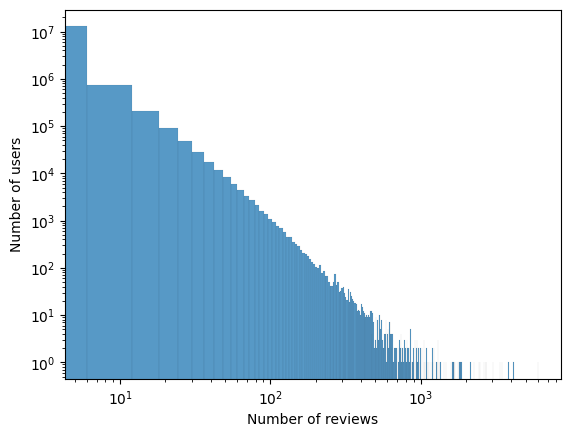

In [8]:
h = sns.histplot(data=clean_users, x="reviews", bins=1000)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of users")
plt.xlabel("Number of reviews")

### Plotting an histogram of the count of games

This time, the density decreases more slowly but still follows a power distribution.

It is not surprising to see that 32% of all users have more than 100 games in their library because:
- Steam encourages collecting video games by giving badges based on the amount of games bought.
- There are often games/dlcs sold in bulk at a cheaper rate.
- So, the Steam "collection" feature turns people into game collector as it is often discussed on forums online, inter alia, due to lower cost of storage, faster bandwith, discounts on bundles, feeling of gratification..



No users with >100 games: 4557001


Text(0.5, 0, 'Number of games bought')

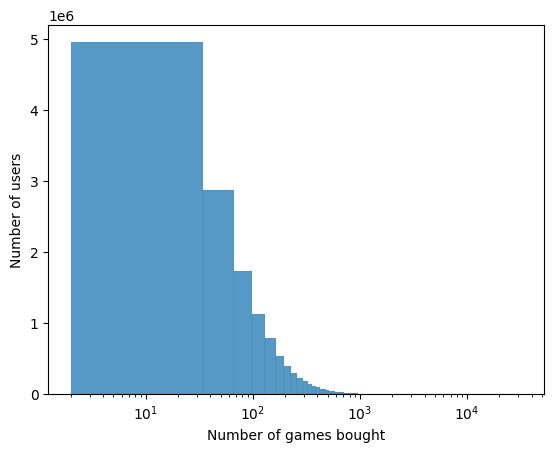

In [9]:
print("No users with >100 games:", clean_users[clean_users["products"] >= 100]["products"].count())
up = sns.histplot(data=clean_users, x="products", bins=1000)
plt.xscale("log")
plt.ylabel("Number of users")
plt.xlabel("Number of games bought")

In [95]:
# Normalize number of reviews/rating, for further processing

def normalize_df(df, cols=[], opt="StandardScaler"): 
    df_normalized = df.copy()  # Create a copy of the original dataframe to avoid modifying it directly
    # Normalize only the specified columns
    if (opt == "StandardScaler"):
        df_normalized[cols] = (df[cols] - df[cols].mean()) / df[cols].std()
    elif (opt == "MinMaxScaler"):
        df_normalized[cols] = (df[cols] - df[cols].min()) / (df[cols].max() - df[cols].min())
    elif (opt == "RobustScaler"):
        df_normalized[cols] = (df[cols] - df[cols].median()) / (df[cols].quantile(0.75) - df[cols].quantile(0.25))
    return df_normalized

normalized_clean_users = normalize_df(clean_users, cols=["products", "reviews"], opt="RobustScaler")

### Games.Csv

In [5]:
# Convert rating to a numeric value
rating_mapping = {
  'Overwhelmingly Positive': 8,
  'Very Positive': 7,
  'Positive': 6,
  'Mostly Positive': 5,
  'Mixed': 4,
  'Mostly Negative': 3,
  'Negative': 2,
  'Very Negative': 1,
  'Overwhelmingly Negative': 0
}

num_merged_games_df = merged_games_df.copy()
num_merged_games_df["rating"] = merged_games_df["rating"].replace(rating_mapping).infer_objects()
num_merged_games_df.head(2)

C:\Users\A\AppData\Local\Temp\ipykernel_16088\3156645416.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  num_merged_games_df["rating"] = merged_games_df["rating"].replace(rating_mapping).infer_objects()


app_id                              title date_release   win    mac  linux  \
0   13500  Prince of Persia: Warrior Within™   2008-11-21  True  False  False   
1   22364            BRINK: Agents of Change   2011-08-03  True  False  False   

   rating  positive_ratio  user_reviews  price_final  price_original  \
0       7              84          2199         9.99            9.99   
1       6              85            21         2.99            2.99   

   discount  steam_deck                                        description  \
0       0.0        True  Enter the dark underworld of Prince of Persia ...   
1       0.0        True                                                      

                                                tags  
0  [Action, Adventure, Parkour, Third Person, Gre...  
1                                           [Action]

Axes(0.125,0.11;0.62x0.77)


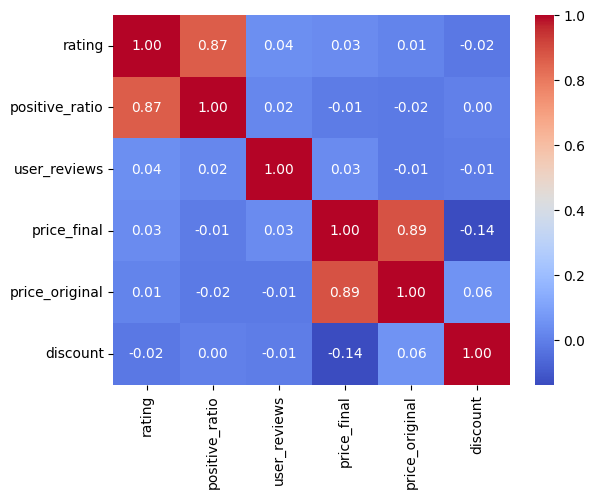

In [6]:
game_num_cols = num_merged_games_df.select_dtypes(include=['number']).drop(columns=["app_id"])
# Show correlation matrix
print(sns.heatmap(game_num_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f"))

As exepected, higher ratings have a high positive ratio. The original and final price are postively correlated.

The other variables are not correlated at all.

In [51]:
px.scatter(data_frame=num_merged_games_df, x='price_original', y='price_final', hover_data=["title", "discount"])

The price trend is linear. There are unusual values on the left (orignal price at 0), maybe due data retrieval errors.

It seems that the final price is after discount only, so it doesn't account for increases in prices.

In [7]:
agg_df = num_merged_games_df.groupby('rating').agg(
    positive_ratio_min=('positive_ratio', 'min'),
    positive_ratio_max=('positive_ratio', 'max'),
    nb_reviews_mean=('user_reviews', 'mean')
).reset_index()
agg_df['nb_reviews_mean'] = agg_df['nb_reviews_mean'].round(1)
agg_df = agg_df.sort_values(by='rating', ascending=[True])


# TODO: Show agg_df 

0 = Overwhelmingly negative

1 = Overwhelmingly positive

This explains the relation between the positive ratio, the rating (Overwhelmingly negative/positive... ) and the number of reviews.

The rating is set primarily by the amount of reviews, then if they are positive or not (as the min/max can overlap).

Visualize words frequency in Games to uncover topic models from the games's description.

# TODO: Remove symbols

In [53]:
nltk.download('stopwords')
def preprocess(documents):
    stop_words = set(stopwords.words('english'))
    
    tokenized_docs = [
        [word for word in doc.split() if word.lower() not in stop_words]
        for doc in documents
    ]
    
    dictionary = corpora.Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]
    
    corpus_cleaned = [
        [(word_id, value.real) if isinstance(value, complex) else (word_id, value) 
         for word_id, value in doc]
        for doc in corpus
    ]
    
    return corpus_cleaned, dictionary

def get_viz(corpus, dictionary, num_topics=2):
    lda = models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    
    for topic_id in range(lda.num_topics):
        for term_id, weight in lda.get_topic_terms(topic_id):
            if isinstance(weight, complex):
                print(f"Complex value found in topic {topic_id}: {weight}")
                weight = weight.real

    viz = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
    return viz

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\A\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
filtered_desc_df = merged_games_df[merged_games_df["description"].notna() & (merged_games_df["description"] != "")]
corpus, dictionary = preprocess(filtered_desc_df["description"])
viz = get_viz(corpus, dictionary, 9)

In [ ]:
pyLDAvis.display(viz)

## Most played games (in hours, by the time of the review) by year

In [8]:
# Convert date
recommendations_df['date'] = pd.to_datetime(recommendations_df['date'])
recommendations_df['year'] = recommendations_df['date'].dt.year

In [15]:
def show_duplicated_reviews(df):
    review_count = df.groupby(['app_id', 'user_id', 'hours']).size().reset_index(name='review_count')
    duplicate_reviews = review_count[review_count['review_count'] > 1]
    return duplicate_reviews

duplicated_reviews = show_duplicated_reviews(recommendations_df)
print(duplicated_reviews)

          app_id     user_id  hours  review_count
2815297   270880   8354604.0  143.0             2
8573256  1142710  11640276.0  327.8             2


Remove duplicate reviews/keep most recent review

In [9]:
recommendations_sorted_df = recommendations_df.sort_values(by=['app_id', 'user_id', 'date'], ascending=[True, True, False])
# Remove duplicates, keeping the first (most recent) occurrence
recommendations_unique_df = recommendations_sorted_df.drop_duplicates(subset=['app_id', 'user_id'], keep='first')

In [ ]:
# Join dataframe on app_id to get title, date_release and tags

info_df = merged_games_df[["app_id", "title", "date_release", "tags"]]
rec_unique_full_df = recommendations_unique_df.copy()

rec_unique_full_df.loc[:, 'app_id'] = rec_unique_full_df['app_id'].astype('int64')
info_df.loc[:, 'app_id'] = info_df['app_id'].astype('int64')

rec_unique_full_df = pd.merge(rec_unique_full_df, info_df, on='app_id', how='left')

# Fill NaN with 0
rec_unique_full_df['is_recommended'] = rec_unique_full_df['is_recommended'].fillna(0).astype('bool')

rec_unique_full_df.head(1)

app_id  helpful  funny       date  is_recommended  hours  user_id  \
0      10        0      0 2020-07-03            True  125.8  11922.0   

    review_id    year           title date_release  \
0  10470080.0  2020.0  Counter-Strike   2000-11-01   

                                                tags  
0  [Action, FPS, Multiplayer, Shooter, Classic, T...

In [11]:
# Convert boolean to 1 or 0

rec_unique_full_df["is_recommended"] = rec_unique_full_df["is_recommended"].replace({True: 1, False: 0}).infer_objects()
rec_unique_full_df.head(1)

C:\Users\A\AppData\Local\Temp\ipykernel_16088\1941964745.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rec_unique_full_df["is_recommended"] = rec_unique_full_df["is_recommended"].replace({True: 1, False: 0}).infer_objects()


app_id  helpful  funny       date  is_recommended  hours  user_id  \
0      10        0      0 2020-07-03               1  125.8  11922.0   

    review_id    year           title date_release  \
0  10470080.0  2020.0  Counter-Strike   2000-11-01   

                                                tags  
0  [Action, FPS, Multiplayer, Shooter, Classic, T...

Aggregate by `hour`

In [44]:
agg_rec_df = rec_unique_full_df.groupby(['app_id', 'year', 'title', 'date_release'])['hours'].sum().reset_index()
agg_rec_df = agg_rec_df.sort_values(by='hours', ascending=True)
agg_rec_df.head(1)

app_id    year                         title date_release  hours
3828  495050  2021.0  Mega Man Legacy Collection 2   2017-08-08    0.1

Issue:

games.csv and recommendations.csv have incoherent values, due to how the data was retreived.

Example: The game `495050` has been played 6 minutes in total according to `recommendations.csv` but it has 991 reviews (87% positive). 

Aggregate by `is_recommended`

In [45]:
agg_norec_df = rec_unique_full_df.groupby(['app_id', 'year', 'title', 'date_release'])['is_recommended'].sum().reset_index().rename(columns={'is_recommended': 'total_recommendations'})
agg_norec_df = agg_norec_df.sort_values(by='total_recommendations', ascending=False)
agg_norec_df.head(2)

app_id    year          title date_release  total_recommendations
6327  1938090  2022.0  Call of Duty®   2022-10-27                  84712
2032   252490  2022.0           Rust   2018-02-08                  70774

In [56]:
def plot_top_5(df, attr, title, hover_data, top5=True):
    if (top5):
        top_5_hours_per_year = df.groupby('year').apply(lambda x: x.nlargest(5, attr)).reset_index(drop=True)
    else:
        top_5_hours_per_year = df
    fig = px.bar(
        top_5_hours_per_year, 
        x='year', 
        y=attr, 
        color='title', 
        title=title, 
        labels={'year': 'Year', 'hours': 'Total Hours Played'},
        barmode='stack',
        hover_data=hover_data
    )

    # Show the plot
    fig.show()

plot_top_5(agg_rec_df, "hours", "Top 5 Most Played Games by Year (by the time of the review)", hover_data={
    'title': True,
    'hours': True,
    'year': False,
    'date_release': True
})

C:\Users\A\AppData\Local\Temp\ipykernel_16088\102382662.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Only the most recent review per user is kept. So that, the hours played count only once.

Not a problem because: there are only 4 reviews of 2 different games by the same user, with "0 hours time-played" difference between the two reviews.

## Top 5 recommended games by year

Number of recommendations per year

In [73]:
plot_top_5(agg_norec_df, "total_recommendations", "Top 5 Most Recommended Games by Year (by the time of the review)", hover_data={
    'title': True,
    'total_recommendations': True,
    'year': False,
    'date_release': True
})

C:\Users\A\AppData\Local\Temp\ipykernel_13232\1376667037.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [32]:
rec_unique_full_df["user_id"] = rec_unique_full_df["user_id"].astype("Int64")

The user with the most reviews, unfortunately the dataframe only has 83 of his reviews? But we can still plot them.

In [72]:
# Count the number of rows where user_id is 11764552 (best reviewer) and hours > 3
count_filtered = rec_unique_full_df[(rec_unique_full_df["user_id"] == 11764552) & (rec_unique_full_df["hours"] > 3)].shape[0]
count_total = rec_unique_full_df[rec_unique_full_df["user_id"] == 11764552].shape[0]
ratio = count_filtered / count_total
print("User with the most review (6k, but 83 in recommendations.csv), ratio played-more-than-3h: ", round(ratio, 2) * 100, "%")
most_reviews_user_df = rec_unique_full_df[rec_unique_full_df["user_id"] == 11764552] 
plot_top_5(most_reviews_user_df, "hours", "Hours Played per Game (best reviewer)", hover_data=["title", "hours"], top5=False)

User with the most review (6k, but 83 in recommendations.csv), ratio played-more-than-3h:  54.0 %


# TODO: Most recommended + played genres by year

# Recommendation

## Capture Latent Variables

In [12]:
# We only keep user_id, safe_title, is_recommended is last
result = rec_unique_full_df[['user_id', 'title', 'is_recommended']].copy()
result['title'] = result['title'] + ' (' + rec_unique_full_df['app_id'].astype(str) + ')'
result.rename(columns={"title": "safe_title"}, inplace=True)

# There's 1 NA number
result['is_recommended'] = result['is_recommended'].fillna(0).astype(int)
result["user_id"] = result["user_id"].fillna(0).astype(int)

In [22]:
reader = Reader(rating_scale=(0, 1)) # Recommended/Not recommended
rec_data = Dataset.load_from_df(result, reader)
rec_trainset = rec_data.build_full_trainset() # Preprocessing (Converts string to integer...)
game_titles = [rec_trainset.to_raw_iid(x) for x in range(len(rec_trainset.all_items()))]

In [23]:
svd_15 = SVD(n_factors=15)
svd_15.fit(rec_trainset)

# Get the latent movie features
latent_game_features_15 = svd_15.qi

# Apply TSNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=10)
tsne_results = tsne.fit_transform(latent_game_features_15)

Color point based on "belongs, or not, to genre" and shape based on released year.? 

In [24]:
# Prepare data for plotting
df_tsne = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
df_tsne['Game'] = game_titles

# Create an interactive scatter plot
fig = px.scatter(df_tsne, x="TSNE1", y="TSNE2", title="Games in Latent Space", hover_data={'Game': True})

fig.update_traces(text='none')
fig.show()

In [25]:
df_tsne[df_tsne["Game"].str.contains("Counter-Strike", case=False, na=False)]

TSNE1      TSNE2                                    Game
0  -10.430034   0.747442                     Counter-Strike (10)
3   -2.900431  11.921618            Counter-Strike: Source (240)
12 -18.784166  -5.686283  Counter-Strike: Global Offensive (730)

# Map of Games

## Dimensionality Reduction (PCA)

In [53]:
result.shape

(10826523, 3)

The 4M should be picked randomly, but each title should appear at least once, the best would be to keep the proportions.

In [13]:
def stratified_sample_df(df, col, n_samples):
  df_ = df.groupby(col, group_keys=False).apply(lambda x: x.sample(int(np.rint(n_samples*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)
  return df_

stratified_sample_result = stratified_sample_df(result, "safe_title", 1_000_000)

C:\Users\A\AppData\Local\Temp\ipykernel_16088\982253201.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ = df.groupby(col, group_keys=False).apply(lambda x: x.sample(int(np.rint(n_samples*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)


In [163]:
stratified_sample_result["safe_title"].value_counts() # Frequency of each games

safe_title
Rust (252490)                                              23224
Counter-Strike: Global Offensive (730)                     15990
No Man's Sky (275850)                                      14044
Wallpaper Engine (431960)                                  13860
Grand Theft Auto V (271590)                                13744
                                                           ...  
PGA TOUR 2K23 (1588010)                                        1
Marvel vs. Capcom: Infinite (493840)                           1
Destroyer: The U-Boat Hunter (1272010)                         1
The Legend of Heroes: Trails of Cold Steel IV (1198090)        1
Turnip Boy Commits Tax Evasion (1205450)                       1
Name: count, Length: 1299, dtype: int64

In [27]:
# Pivot matrix so that each row is a game, and each column is a user's recommendation (First 4M because of memory overflow)

result_pivot_df = stratified_sample_result.pivot(columns="user_id", index="safe_title", values="is_recommended").fillna(0)
result_pivot_sparse = scipy.sparse.csr_matrix(result_pivot_df.values) # Save memory

game_titles_1M = result_pivot_df.index.tolist()
del result_pivot_df  # Free memory

There are 1299 unique games left.

In [28]:
svd50_ratings_pivot = TruncatedSVD(n_components=50)
svd_ratings50_pivot = svd50_ratings_pivot.fit_transform(result_pivot_sparse)
svd_tsne50_ratings_pivot = TSNE(n_components=2, learning_rate='auto', init="random", perplexity=10).fit_transform(svd_ratings50_pivot)

In [29]:
pca50_ratings_pivot = PCA(n_components=50)
pca_ratings50_pivot = pca50_ratings_pivot.fit_transform(result_pivot_sparse)
pca_tsne50_ratings_pivot = TSNE(n_components=2, learning_rate='auto', init="random", perplexity=10).fit_transform(pca_ratings50_pivot)

In [299]:
svd_fig = px.scatter(x=svd_tsne50_ratings_pivot[:, 0], y=svd_tsne50_ratings_pivot[:, 1], hover_name=game_titles_1M, title="SVD - Games in Latent Space")
svd_fig.show()

In [300]:
pca_fig = px.scatter(x=pca_tsne50_ratings_pivot[:, 0], y=pca_tsne50_ratings_pivot[:, 1], hover_name=game_titles_1M, title="PCA - Games in Latent Space")
pca_fig.show()

## Correlation to Network

### Similarity Matrix

Observation:

cosine similarity yields poor result (only very low threshold doesn't lead to an identity matrix ~ 0.0001)

Maybe try jaccard similarity as it's more suitable for binary data? (is_recommended is 0 or 1).

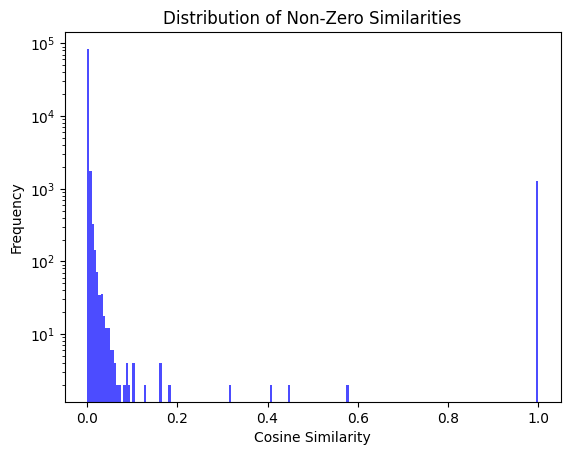

In [30]:
cosine_sim_matrix = cosine_similarity(result_pivot_sparse)

non_zero_similarities = cosine_sim_matrix[cosine_sim_matrix > 0].flatten()

# Plot distribution to understand where meaningful thresholds might be
plt.hist(non_zero_similarities, bins=200, color='blue', alpha=0.7)
plt.title("Distribution of Non-Zero Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()

In [31]:
threshold = 0.005 # very weak connections, but it's because the matrix is too sparse... might represent noise
cosine_sim_matrix[cosine_sim_matrix < threshold] = 0
len(np.unique(cosine_sim_matrix))

1566

### Network

In [27]:
def graph_from_sim_matrix(matrix, titles):
    new_graph = nx.Graph()

    # Add node as intger
    for i in range(len(titles)):
      new_graph.add_node(i, title=titles[i])

    # Add edges on similarity
    for i, row in enumerate(matrix):
      for j, similarity in enumerate(row):
        if similarity > 0 and i != j:  # Exclude self-loops
          new_graph.add_edge(i, j, weight=similarity)

    # Remove singletons and self-loops
    new_graph.remove_edges_from(nx.selfloop_edges(new_graph))
    new_graph.remove_nodes_from(list(nx.isolates(new_graph)))

    # To ensure continuous range of node indices (to avoid issues with node2vec)
    new_graph = nx.convert_node_labels_to_integers(new_graph)

    return new_graph

def plot_graph(graph, title, max_labels=50):
    pos = nx.spring_layout(graph, seed=42)
    
    plt.figure(figsize=(16, 12))
    nx.draw_networkx_nodes(graph, pos, node_size=20, node_color='blue', alpha=0.7)
    nx.draw_networkx_edges(graph, pos, edge_color='gray', alpha=0.5)
    
    labels = {}
    for node in list(graph.nodes)[:max_labels]:
      labels[node] = graph.nodes[node]['title']
    
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8, font_color='red')
    
    plt.title(title)
    plt.show()
  
def save(graph, path):
  nx.write_gexf(graph, path)
  print("Saved.")

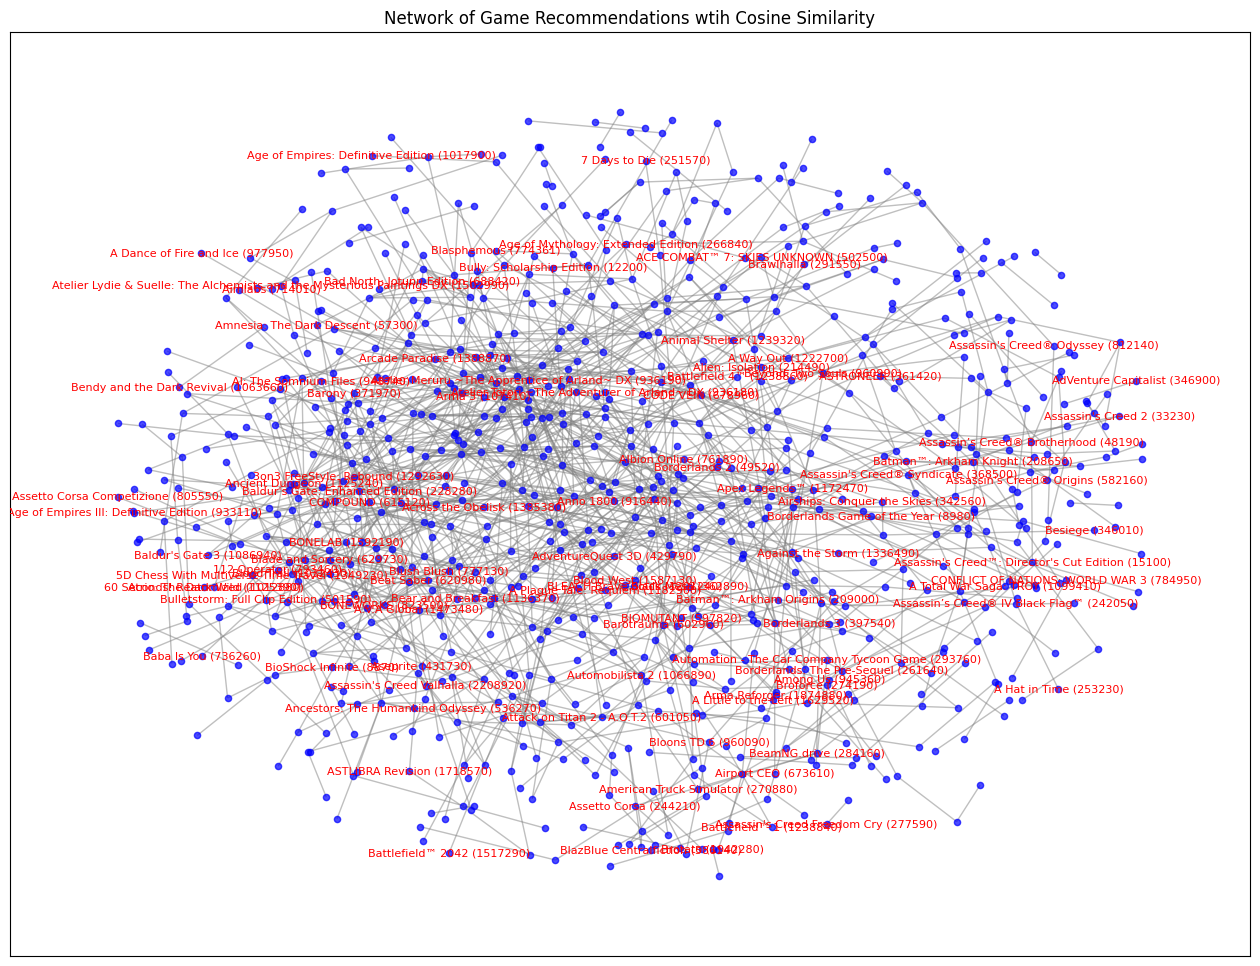

There are only 865 games (nodes) left after discarding singletons and self loops
Saved.


In [ ]:
graph_cosine_sim_matrix = graph_from_sim_matrix(cosine_sim_matrix, game_titles_1M)
plot_graph(graph_cosine_sim_matrix, "Network of Game Recommendations wtih Cosine Similarity", max_labels=100)
save(graph_cosine_sim_matrix, "cos_sim_graph.gexf")
print(f"There are only {len(list(graph_cosine_sim_matrix.nodes))} games (nodes) left after discarding singletons and self loops")

# TODO: same with Jaccard similarity and compare + use Gephi

### Graph embedding

In [14]:
# Fit Node2Vec on graph to get embeddings
def train_node2vec_graph(graph):
  node2vec = Node2Vec(dimensions=8, walk_length=10, workers=4)
  node2vec.fit(graph)

  node_embeddings = node2vec.get_embedding()

  node_tsne_2D = TSNE(n_components=2, learning_rate='auto', init="random", perplexity=10).fit_transform(node_embeddings)
  node_pca_2D = PCA(n_components=2).fit_transform(node_embeddings)

  return node_tsne_2D, node_pca_2D, node_embeddings

def plot_graph_embedding_with_px(title, nodes_reduc, graph):
  x = nodes_reduc[:, 0]
  y = nodes_reduc[:, 1] 
  
  hover_data = [graph.nodes[node]['title'] for node in list(graph.nodes)]

  fig = px.scatter(x=x, y=y, title=title, hover_name=hover_data)

  fig.update_traces(marker=dict(size=7, color='blue', opacity=0.7), )

  fig.update_layout(height=800, width=1000, showlegend=False)

  fig.show()

def plot_graph_clusters(title, nodes_reduc, labels, graph):
    x = nodes_reduc[:, 0]
    y = nodes_reduc[:, 1]

    hover_data = [graph.nodes[node]['title'] for node in list(graph.nodes)]

    fig = px.scatter(x=x, y=y, title=title, color=labels.astype(str), hover_name=hover_data)

    fig.update_traces(marker=dict(size=7, opacity=0.7))
    fig.update_layout(height=800, width=1000, showlegend=True)
    fig.show()



In [15]:
node_tsne_2D, node_pca_2D, node_embeddings = train_node2vec_graph(graph_cosine_sim_matrix)

NameError: name 'graph_cosine_sim_matrix' is not defined

In [38]:
plot_graph_embedding_with_px("Graph embedding with TSNE (cosine similarity)", node_tsne_2D, graph_cosine_sim_matrix)
plot_graph_embedding_with_px("Graph embedding with PCA (cosine similarity)", node_pca_2D, graph_cosine_sim_matrix)

The proximity of nodes in the graph embedding space reflects not only how similar two items are, but also how connected they are within the entire graph.

TSNE seems to yield interesting result with clusters with more defined borders. Similar games (Assassin's Creed) are very close to one another (top left group), compared to previous results.

### Clustering

Let's apply clustering on the dimensionality reduced values, as I want to visualize them, even if I may lose informations.

### DBScan & Gaussian Mixture on TSNE

In [ ]:
# DBScan

dbscan_tsne = DBSCAN(eps=3.1, min_samples=3, metric='euclidean') # If eps is tool small -> -1 (noise)
dbscan_labels_tsne = dbscan_tsne.fit_predict(node_tsne_2D)

dbscan_pca = DBSCAN(eps=0.4, min_samples=3, metric='euclidean')
dbscan_labels_pca = dbscan_pca.fit_predict(node_pca_2D)

# Bayesian Gaussian Mixture found 4 clusters

bgm_tsne = BayesianGaussianMixture(n_components=4, max_iter=500, covariance_type='diag')
bgm_labels_tsne = bgm_tsne.fit_predict(node_tsne_2D)

bgm_pca = BayesianGaussianMixture(n_components=4, max_iter=500, covariance_type='diag')
bgm_labels_pca = bgm_pca.fit_predict(node_pca_2D)

In [40]:
plot_graph_clusters("DBSCAN Clusters with TSNE", node_tsne_2D, dbscan_labels_tsne, graph_cosine_sim_matrix)
plot_graph_clusters("DBSCAN Clusters with PCA", node_pca_2D, dbscan_labels_pca, graph_cosine_sim_matrix)

In [337]:
plot_graph_clusters("Bayesian Gaussian Mixture Clusters with TSNE", node_tsne_2D, bgm_labels_tsne, graph_cosine_sim_matrix)
plot_graph_clusters("Bayesian Gaussian Mixture Clusters with PCA", node_pca_2D, bgm_labels_pca, graph_cosine_sim_matrix)

Silhouette score:

- +1: Perfectly compact and well-separated clusters.
- 0: Clusters overlap significantly, or points are equidistant between clusters.
- -1: Points are assigned to the wrong clusters.

In [41]:
silhouette_tsne = silhouette_score(node_tsne_2D, dbscan_labels_tsne)
print(f"Silhouette Score for DBSCAN (TSNE): {silhouette_tsne}")

silhouette_pca = silhouette_score(node_pca_2D, dbscan_labels_pca)
print(f"Silhouette Score for DBSCAN (PCA): {silhouette_pca}")

silhouette_bgm_tsne = silhouette_score(node_tsne_2D, bgm_labels_tsne)
print(f"Silhouette Score for BGM (TSNE): {silhouette_bgm_tsne}")

silhouette_bgm_pca = silhouette_score(node_pca_2D, bgm_labels_pca)
print(f"Silhouette Score for BGM (PCA): {silhouette_bgm_pca}")


Silhouette Score for DBSCAN (TSNE): 0.3686519265174866
Silhouette Score for DBSCAN (PCA): -0.19288618862628937
Silhouette Score for BGM (TSNE): 0.33098864555358887
Silhouette Score for BGM (PCA): 0.2856767475605011


I didn't expect the BGM to be better at clustering than DBScan on this dataset with this metric (at least visually and when checking game by game).

All in all, the scores are quite low, and when checking manually, the games inside the same cluster don't appear to be too related.

# Frequent Patterns

This time we want to know the most frequent recommended k-itemsets

In [ ]:
del result_pivot_sparse

In [18]:
# Pivot matrix so that each row (transaction) is a user, and each column (item) is a game (First 4M because of memory overflow)

result_pivot_usergame_df = stratified_sample_result.pivot(columns="safe_title", index="user_id", values="is_recommended").fillna(0)
result_pivot_usergame_df = result_pivot_usergame_df.astype('uint8') # To save memory
result_pivot_usergame_df.shape

(899055, 1299)

### Extracting frequent patterns with apriori

In [19]:
# Discover frequent itemsets appearing in at least 0.0005% of the transactions (out of 1 million)
apriori_result = frequent_patterns.apriori(result_pivot_usergame_df, min_support=0.000005, max_len=3, use_colnames=True, low_memory=True)

c:\Users\A\Code\personal\master\Data Mining\TP\Projet\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [20]:
# Force display columns in full, descending order
pd.set_option("display.max_colwidth", None)
apriori_result.sort_values("support", ascending=False)

support                                                    itemsets
742   0.021598                                             (Rust (252490))
182   0.015450                    (Counter-Strike: Global Offensive (730))
985   0.015138                                 (Wallpaper Engine (431960))
328   0.012134                                        (Fallout 4 (377160))
607   0.012015                                     (No Man's Sky (275850))
...        ...                                                         ...
4213  0.000006  (NieR:Automata™ (524220), Resident Evil 4 (2005) (254700))
4212  0.000006         (NieR:Automata™ (524220), Resident Evil 2 (883710))
2483  0.000006        (Project Zomboid (108600), DARK SOULS™ III (374320))
1734  0.000006     (Resident Evil 4 (2005) (254700), Blasphemous (774361))
2891  0.000006            (Half-Life: Alyx (546560), ELDEN RING (1245620))

[5138 rows x 2 columns]

In [21]:
apriori_result[apriori_result["itemsets"].apply(lambda x: len(x) == 2)]

support  \
1052  0.000006   
1053  0.000006   
1054  0.000006   
1055  0.000007   
1056  0.000006   
...        ...   
5133  0.000011   
5134  0.000007   
5135  0.000023   
5136  0.000009   
5137  0.000008   

                                                                                         itemsets  
1052                                     (ARK: Survival Evolved (346110), 7 Days to Die (251570))  
1053                                              (7 Days to Die (251570), No Man's Sky (275850))  
1054                                                  (PAYDAY 2 (218620), 7 Days to Die (251570))  
1055                                           (Project Zomboid (108600), 7 Days to Die (251570))  
1056                                                      (7 Days to Die (251570), SCUM (513710))  
...                                                                                           ...  
5133                      (Warhammer 40000: Darktide (1361210), Warhammer: Vermintide 2 (552500))  
5134  (XCOM: Enemy Unknown (200510), Warhammer 40000: Space Marine - Anniversary Edition (55150))  
5135                                           (Yakuza Kiwami (834530), Yakuza Kiwami 2 (927380))  
5136                                    (Yakuza Kiwami (834530), Yakuza: Like a Dragon (1235140))  
5137                                  (Yakuza Kiwami 2 (927380), Yakuza: Like a Dragon (1235140))  

[4086 rows x 2 columns]

The most 2 frequent items are so unlikely that it is just meaningless on this dataset. (<0.0007%)

But it's not surprising as even the most frequent item in the dataset appears 2.1% times.

There are just too many transactions (1 million) for the number of games, most of which have totally different games.

Maybe instead of 1 = recommended, we could do 1 = bought (is_recommended = 0 or 1), it would increase the likeliness of finding a game at least?

### Association Rules (even though the threshold is way too low)

In [22]:
# Typical scores on frequent patterns

asoc = frequent_patterns.association_rules(apriori_result, num_itemsets=1_000_000, metric="support", min_threshold=0.000005)

In [23]:
asoc.sort_values("lift", ascending=False).head(2)

antecedents  \
2974  (Danganronpa Another Episode: Ultra Despair Girls (555950))   
2975                   (Danganronpa V3: Killing Harmony (567640))   

                                                      consequents  \
2974                   (Danganronpa V3: Killing Harmony (567640))   
2975  (Danganronpa Another Episode: Ultra Despair Girls (555950))   

      antecedent support  consequent support   support  confidence       lift  \
2974            0.000196            0.000753  0.000007    0.034091  45.272677   
2975            0.000753            0.000196  0.000007    0.008863  45.272677   

      representativity  leverage  conviction  zhangs_metric   jaccard  \
2974               1.0  0.000007    1.034515       0.978103  0.007084   
2975               1.0  0.000007    1.008744       0.978649  0.007084   

      certainty  kulczynski  
2974   0.033363    0.021477  
2975   0.008669    0.021477

### From frequent patterns to graphs

Fortunately the lift metric balance it out

We only keep rules like game1 -> game2, and lift > 5

In [24]:
la = asoc[asoc["antecedents"].apply(lambda x: len(x) == 1) & asoc["consequents"].apply(lambda x: len(x) == 1) & asoc['lift'].apply(lambda x: x > 2)]
la.loc[:, 'antecedents'] = la['antecedents'].apply(lambda x: next(iter(x))).astype(str)
la.loc[:, 'consequents'] = la['consequents'].apply(lambda x: next(iter(x))).astype(str)
la.shape

(506, 14)

c:\Users\A\Code\personal\master\Data Mining\TP\Projet\.venv\Lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


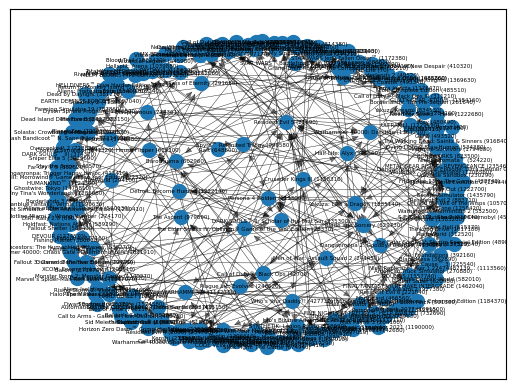

In [25]:
edges = list(zip(la['antecedents'], la['consequents']))
G = nx.DiGraph()

G.add_edges_from(edges)

pos = nx.spring_layout(G, k=1.3, scale=2)
nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.get_cmap("Accent"))
nx.draw_networkx_edges(G, pos, edgelist=edges, width=0.3, alpha=0.5, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=4)
plt.show()


### Interactive version, see frequent_graph.html

In [ ]:
from pyvis.network import Network
import pandas as pd

net = Network(notebook=True, width="100%", height="800px", directed=True)

for index, row in la.iterrows():
    # Ensure that the antecedents and consequents are strings
    antecedent_name = str(row['antecedents'])
    consequent_name = str(row['consequents'])
    
    # Add nodes with label (this ensures node names are shown on hover)
    net.add_node(antecedent_name, label=antecedent_name, title=antecedent_name)
    net.add_node(consequent_name, label=consequent_name, title=consequent_name)
    
    # Add directed edges
    net.add_edge(antecedent_name, consequent_name)

net.force_atlas_2based()
net.set_options("""
var options = {
  "nodes": {
    "borderWidth": 2,
    "borderWidthSelected": 4,
    "size": 15,
    "font": {
      "size": 12
    }
  },
  "edges": {
    "arrows": {
      "to": {
        "enabled": true
      }
    },
    "color": {
      "inherit": true
    },
    "smooth": {
      "enabled": true
    }
  },
  "physics": {
    "enabled": true
  }
}
""")

# Show the network in an interactive plot
net.show("frequent_graph.html")

Visually it works even better than previous methods despite my very low min_threshold, which I didn't expect.

The linked games have a lot in common:

For instance Europa Universalis IV, Victoria 3 and Crusader Kings III & II are interlinked.
- They are made by the same studio, Paradox, famous for publishing complex and in-depth 4X and grand-strategy games.
- The 3 games are map-games, set before XIX century.
- In all those games, you have to manage economy, diplomacy and war.
- But Victoria 3 is more economy-oriented, while CK is dynasty-oriented, and EU4 is state-oriented.

[Paradox](./img/frequent_graph/4x_strategy_2.png)

Other examples:

[Simulator](./img/frequent_graph/simulator.png)

[War](./img/frequent_graph/war.png)

[Racing Sim](./img/frequent_graph/racing_sim.png)

Etc..

In [29]:
edges = list(zip(la['antecedents'], la['consequents']))
G_full = nx.DiGraph()

for index, row in la.iterrows():
    antecedent = row['antecedents']
    consequent = row['consequents']
    # Add nodes with more attributes
    G_full.add_node(antecedent, support=row['antecedent support'], confidence=row['confidence'], lift=row['lift'])
    G_full.add_node(consequent, support=row['consequent support'])

    G_full.add_edge(antecedent, consequent, support=row['support'], lift=row['lift'])

save(G_full, "frequent_digraph_full.gexf")

Saved.
